In [1]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm



In [2]:
Inflation_data = pd.read_csv('/Users/ismatahmed/neuefische/da_capstone_group3/data/Inflationsdaten.csv', delimiter=';', encoding='latin')
Inflation_data.head()

,Jahre,Verbraucherpreisindex,Veraenderung zum Vorjahr
0,1991,"61,9",0
1,1992,"65,0","5,0"
2,1993,"67,9","4,5"
3,1994,"69,7","2,7"
4,1995,"71,0","1,9"


In [3]:
Inflation_data['Jahre'] = pd.to_datetime(Inflation_data['Jahre'], format='%Y')

In [4]:
Inflation_data.set_index('Jahre', inplace=True)

In [5]:
Inflation_data['Verbraucherpreisindex'] = Inflation_data['Verbraucherpreisindex'].str.replace(',', '.').astype(float)


In [6]:
Inflation_data.head(5)

,Verbraucherpreisindex,Veraenderung zum Vorjahr
Jahre,,
1991-01-01,61.9,0
1992-01-01,65.0,"5,0"
1993-01-01,67.9,"4,5"
1994-01-01,69.7,"2,7"
1995-01-01,71.0,"1,9"


In [7]:
Inflation_data['Veraenderung zum Vorjahr'] = Inflation_data['Veraenderung zum Vorjahr'].str.replace(',', '.').astype(float)

In [8]:
from sql_functions import get_engine
engine = get_engine()

In [9]:
table_name = 'yearly_inflation'
schema = 'public'

In [10]:
# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        Inflation_data.to_sql(name=table_name, # Name of SQL table variable
                        con= engine, # Engine or connection
                        schema=schema, # your class schema variable
                        if_exists='replace', # Drop the table before inserting new values 
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
else:
    print('No engine')

The yearly_inflation table was imported successfully.


In [11]:
#check wether data is stationary
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [12]:
check_stationarity(Inflation_data['Veraenderung zum Vorjahr'])

The series is NOT stationary


In [13]:
#calculate difference
Inflation_data['Inflation_diff'] = Inflation_data['Veraenderung zum Vorjahr'].diff()

# Drop the first row with NaN since differencing results in a NaN for the first row
Inflation_data.dropna(subset=['Inflation_diff'], inplace=True)

In [14]:
Inflation_data.head(5)

,Verbraucherpreisindex,Veraenderung zum Vorjahr,Inflation_diff
Jahre,,,
1992-01-01,65.0,5.0,5.0
1993-01-01,67.9,4.5,-0.5
1994-01-01,69.7,2.7,-1.8
1995-01-01,71.0,1.9,-0.8
1996-01-01,72.0,1.4,-0.5


In [15]:
check_stationarity(Inflation_data['Inflation_diff'])

The series is stationary


/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


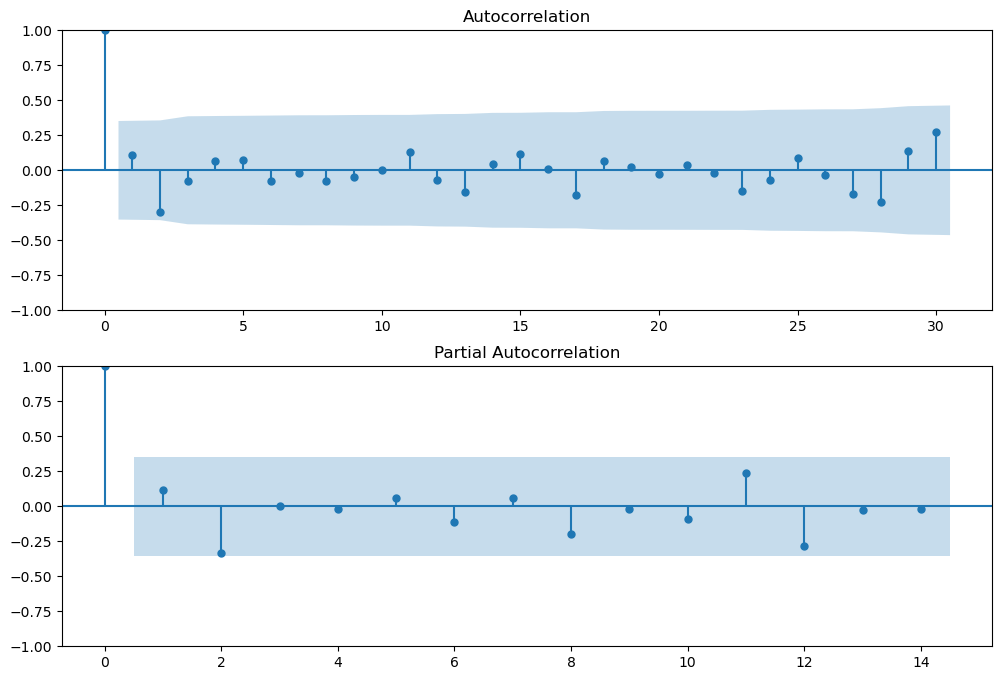

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming inflation_data is your DataFrame with 'Inflation_diff' column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(Inflation_data['Inflation_diff'], lags=30, ax=ax1)
plot_pacf(Inflation_data['Inflation_diff'], lags=14, ax=ax2)
plt.show()

In [17]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Assuming Inflation_data is your DataFrame with 'Verbraucherpreisindex' column
# If the 'Verbraucherpreisindex' column is already numeric, you can skip the following line
# Inflation_data['Verbraucherpreisindex'] = Inflation_data['Verbraucherpreisindex'].str.replace(',', '.').astype(float)

# Calculate first-order differencing
Inflation_data['Inflation_diff'] = Inflation_data['Verbraucherpreisindex'].diff()
Inflation_data.dropna(subset=['Inflation_diff'], inplace=True)

# Create a list of potential orders
p = range(0, 3)  # Replace with appropriate values
d = [1]            # Since we performed first-order differencing
q = range(0, 3)  # Replace with appropriate values
P = range(0, 3)  # Replace with appropriate values
D = [1]            # Since we performed seasonal differencing
Q = range(0, 3)  # Replace with appropriate values
S = 1          # Assuming a seasonal period of 12 months for monthly data

# Create all possible combinations of the orders
order_combinations = list(itertools.product(p, d, q))
seasonal_order_combinations = list(itertools.product(P, D, Q, [S]))

best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Iterate through all combinations and find the best model based on AIC
for order in order_combinations:
    for seasonal_order in seasonal_order_combinations:
        try:
            model = SARIMAX(Inflation_data['Verbraucherpreisindex'], order=order, seasonal_order=seasonal_order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print("Best non-seasonal order (p, d, q):", best_order)
print("Best seasonal order (P, D, Q, S):", best_seasonal_order)


Best non-seasonal order (p, d, q): None
Best seasonal order (P, D, Q, S): None


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54634D+00    |proj g|=  2.04410D-01

At iterate    5    f=  1.48668D+00    |proj g|=  1.30854D-02

At iterate   10    f=  1.48391D+00    |proj g|=  4.04477D-04


/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f=  1.48390D+00    |proj g|=  5.87401D-03

At iterate   20    f=  1.48381D+00    |proj g|=  1.55531D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   1.374D-05   1.484D+00
  F =   1.4838144313732367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:           Veraenderung zum Vorjahr   No. Observations:                   30
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -44.514
Date:                     

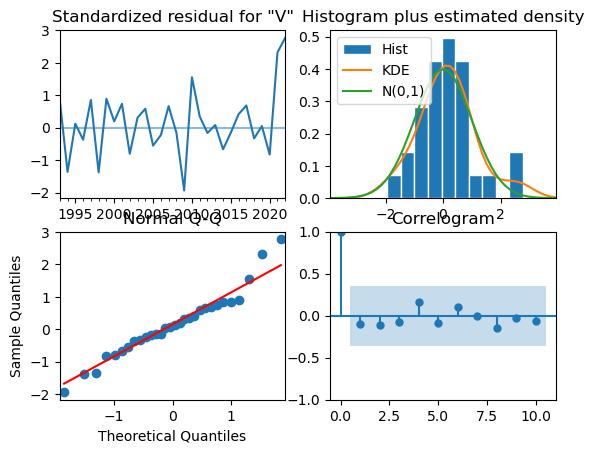

In [18]:
# Fit the SARIMA model with the best orders
final_model = model = sm.tsa.SARIMAX(Inflation_data['Veraenderung zum Vorjahr'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
final_results = final_model.fit()

# Evaluate the model's performance
print(final_results.summary())
final_results.plot_diagnostics()
plt.show()


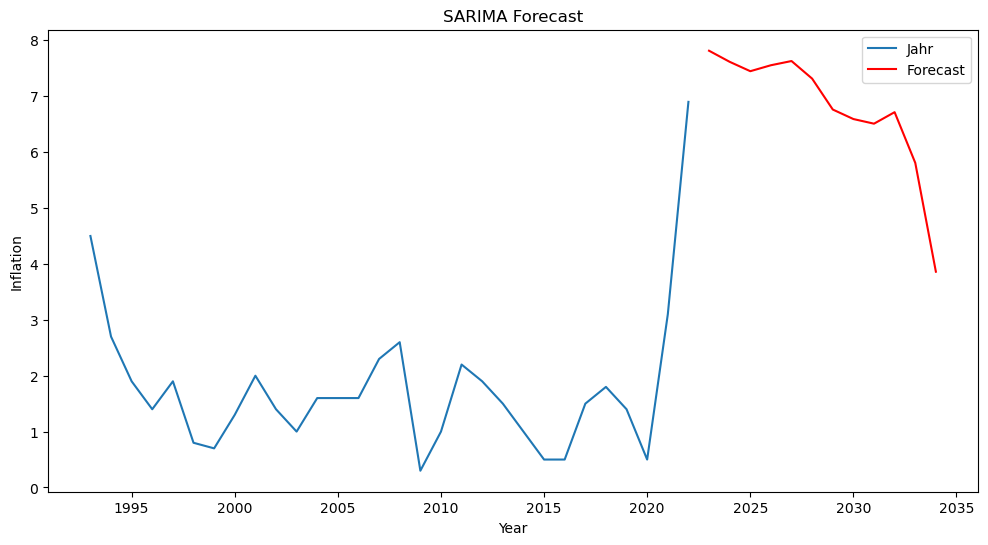

In [19]:
# Forecast future values
forecast_steps = 12 # Assuming you want to forecast 12 months ahead
forecast = final_results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(Inflation_data.index, Inflation_data['Veraenderung zum Vorjahr'], label='Jahr')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='r')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.title('SARIMA Forecast')
plt.show()


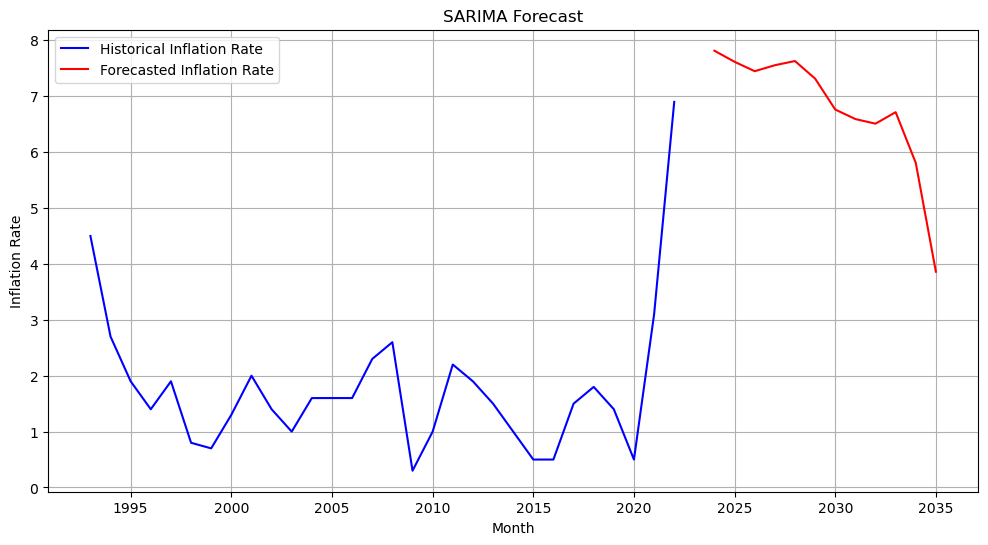

In [20]:
future_dates = pd.date_range(start=Inflation_data.index[-1], periods=forecast_steps + 1, freq='Y')[1:]

# Combine the historical and forecasted data for plotting
all_dates = Inflation_data.index.union(future_dates)
all_inflation = pd.concat([Inflation_data['Veraenderung zum Vorjahr'], pd.Series(forecast_values, index=future_dates)])

# Plot the forecasted inflation rate
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_inflation, label='Historical Inflation Rate', color='blue')
plt.plot(future_dates, forecast_values, label='Forecasted Inflation Rate', color='red')
plt.xlabel('Month')
plt.ylabel('Inflation Rate')
plt.title('SARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()